In [2]:
!pip install piml

# Data Pipeline

In [3]:
from piml import Experiment
exp_tw_credit = Experiment()
exp_bike_sharing = Experiment()
exp_tw_credit.data_loader("TaiwanCredit", silent=True)
exp_bike_sharing.data_loader("BikeSharing", silent=True)

In [4]:
# Display data summary tables
tw_credit_summary = exp_tw_credit.data_summary()
bike_sharing_summary = exp_bike_sharing.data_summary()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='<link rel="stylesheet" href="//stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.…

HTML(value='<link rel="stylesheet" href="//stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.…

### Q1 (5pts): Using PiML, show data summary tables for both data sets.  What is the max value of `cnt` in the bike share data?  How many unique values are there in the `EDUCATION` data point of the Taiwan credit data?

- #### There are 4 unique values for Education and 977 is the max value for 'cnt'

# Model Pipeline

In [5]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

exp_bike_sharing.data_prepare(random_state=100, target="cnt", test_ratio=0.2, task_type="regression", split_method="random", silent=True)
exp_tw_credit.data_prepare(random_state=100, target="FlagDefault", test_ratio=0.2, task_type="classification", split_method="random", silent=True)

exp_bike_sharing.model_train(model=XGBRegressor(max_depth=5, n_estimators=500), name="XGB_Bike_Sharing")
exp_bike_sharing.model_train(model=MLPRegressor(hidden_layer_sizes=[10]*2, activation="relu", random_state=0, early_stopping=True), name="DNN_Bike_Sharing")

exp_tw_credit.model_train(model=XGBClassifier(max_depth=5, n_estimators=500), name="XGB_TW_Credit")
exp_tw_credit.model_train(model=MLPClassifier(hidden_layer_sizes=[10]*2, activation="relu", random_state=0, early_stopping=True), name="DNN_TW_Credit")

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

### Q2 (5pts): What does the `random_state` parameter do?  Will the XGB model for the bike sharing data turn out identical every time you run the code above?

- #### The random_state parameter is used to create reproducibility in models and processes that involve randomness. By setting a fixed value for random_state, you make sure that the random processes involved (such as random splits in data or initialization of model weights) are performed in the same way every time the code is run. XGBoost has multiple areas that have randomness and random state cannot control those creating similar outputs.

### Q3 (2.5pts): What are the hyperparameters specified in each type of model?


- #### XGB model hyperparameters are max_depth and n_estimators, MLP model hyperparameters are ' hidden_layer_sizes, activation function, random state, and early stopping,

## Bike sharing dataset with XGB model and DNN model

### Q4 (10 pts): Compute the reliability table (including empirical coverage and average bandwidth) of the two Bike Sharing models; which model is more reliable?

In [6]:
# Evaluate the reliability for the XGBoost model
reliability_xgb = exp_bike_sharing.model_diagnose(model="XGB_Bike_Sharing", show="reliability_table")

# Evaluate the reliability for the DNN model
reliability_dnn = exp_bike_sharing.model_diagnose(model="DNN_Bike_Sharing", show="reliability_table")

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,Empirical Coverage,Average Bandwidth
0,0.8813,0.1042


,Empirical Coverage,Average Bandwidth
0,0.8856,0.1874


- #### XGBoost has a more narrow bandwith, making it more likely to be reliable than the DNN.

### Q5 (5 pts): Use the `reliability_distance` function in PiML on the XGB model of the bike sharing data.  List the top 5 features that have the largest distributional distance between unreliable regions and reliable regions based on PSI score. (You can use the defaults for all other arguments of `model_diagnose`)


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

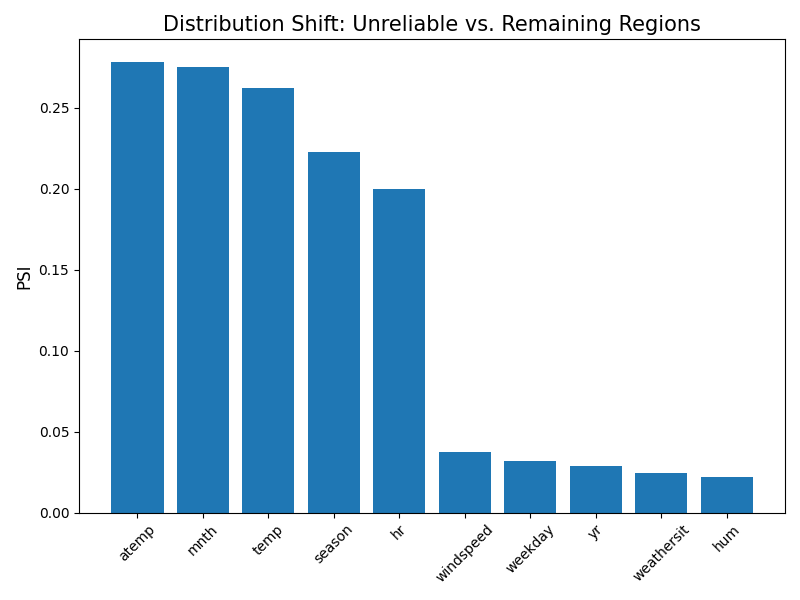

In [7]:
exp_bike_sharing.model_diagnose(model="XGB_Bike_Sharing", show="reliability_distance")

- ### Top 5 Features:
- #### XGB: atemp, mnth, temp, season, hr

### Q6 (5 pts): Do the same analysis as in Q5, but use a threshold of 1.3.  Why did the PSI values increase?


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

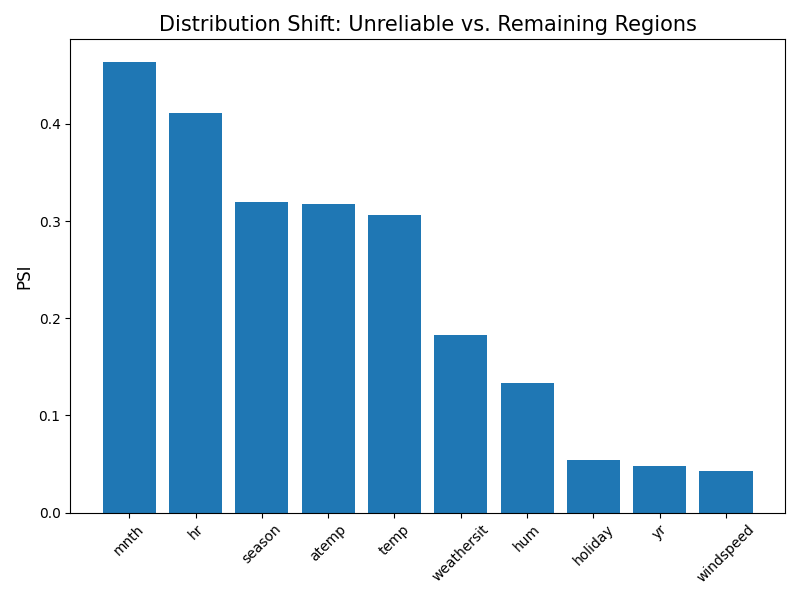

In [8]:
exp_bike_sharing.model_diagnose(model="XGB_Bike_Sharing", show="reliability_distance", threshold= 1.3)

- #### Setting a threshold redefined the region that is considered unreliable changing the impact on the distribution. What was defined as unreliable or not in the previous graphs has changed creating higher PSI values.

### Q7 (2.5 pts): Do the same analysis as in Q6, but use the Wasserstein distance measure instead of PSI.  Are the results the same?


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

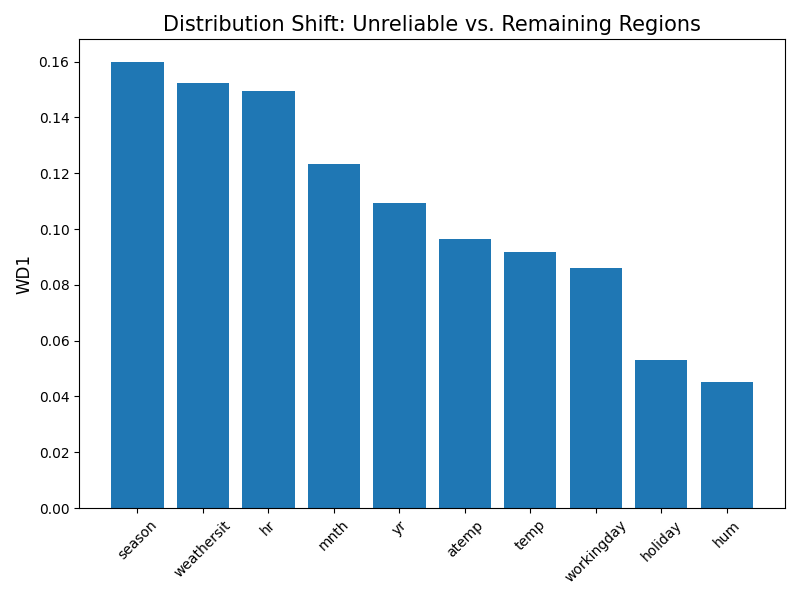

In [9]:
exp_bike_sharing.model_diagnose(model="XGB_Bike_Sharing", show="reliability_distance", threshold= 1.3, distance_metric='WD1')

- #### No they aren't the same because both metrics capture different types of distribution shifts. PSI identifies features with significant changes in their distribution proportions while Wasserstein Distance highlights features that experience a broader shift in distribution shape.

### Q8 (5 pts): Do the same analysis as in Q5, but for the DNN model.  Are the results the same as Q5?  Why or why not?


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

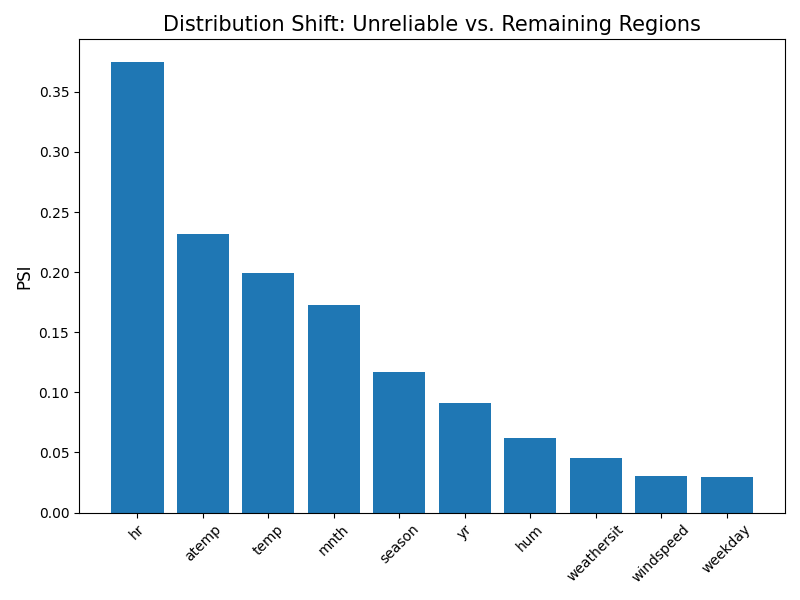

In [10]:
exp_bike_sharing.model_diagnose(model="DNN_Bike_Sharing", show="reliability_distance")

- #### They are not the same, DNN has more sensitivity to hr compared to the XGB model. This could be because of how DNN structure/complexity shifting the data to capture more time-dependent patterns compared to XGB tree splitting algorithmn which specialized in easier splitting terms. DNN also likely handled nonlinear relationships better than XGB.

### Q9 (5 pts): How could the analysis above help you if you were in charge of monitoring a model in production?

- #### These could help detect how severe our model is drifting via our data or feature distirbutions. They could be show us which features are causing the model drift and the overall stability of our model over a time period. Specifying which featurs and monitoring can ensure fairness and decrease biases.

### Q10 (5 pts): For the `XGB_Bike_Sharing` model, write the PiML code to show the weak regions of the `hr` feature.  Use MSE as the measurement metric and include the test data in the results.  Use the `histogram` method for slicing.





HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

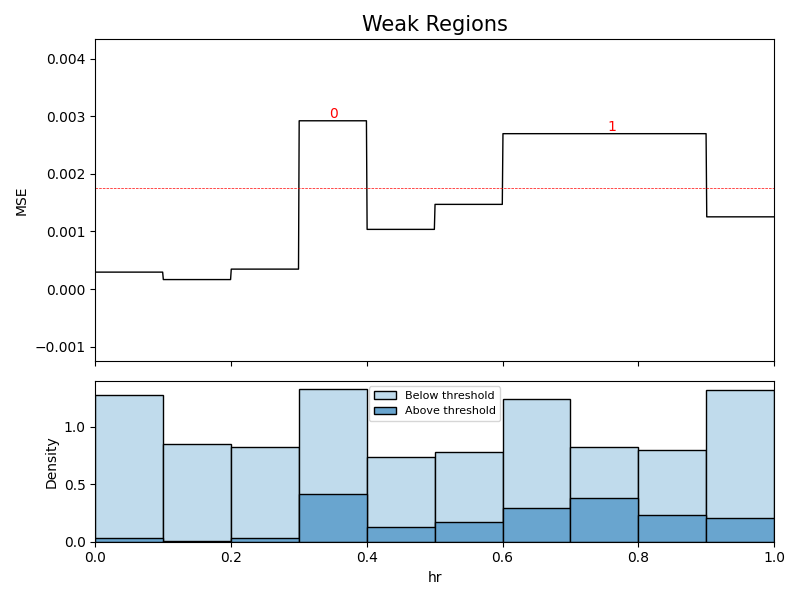

In [20]:
exp_bike_sharing.model_diagnose(model="XGB_Bike_Sharing", show="weakspot", slice_method="histogram", slice_features=["hr"], metric="MSE", use_test=True)

### Q11 (5 pts): Is hour 3 or hour 4 part of a weak region in the analysis of Q10?

- #### Based on the plot, most of both hour 3 and 4 are above the threshold or having a high MSE meaning they are not in weak regions.

### Q12 (5 pts): If you do the same analysis of Q10 for the DNN model, does it have the same weak regions for the `hr` feature?

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

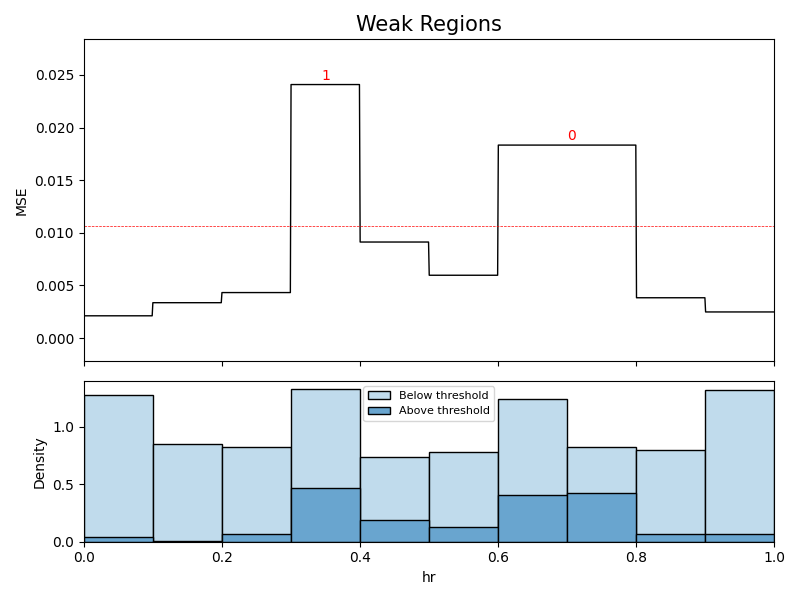

In [19]:
exp_bike_sharing.model_diagnose(model="DNN_Bike_Sharing", show="weakspot", slice_method="histogram", slice_features=["hr"], metric="MSE", use_test=True)

- #### The DNN model does not have the exact same weak regions as the XGB model for the hr feature. DNN has more pronounced errors around certain hours compared to the XGB model, which might be capturing the temporal patterns differently.

### Q13 (5 pts): Do these weak regions mean that the model should not be used?  What might be done to improve the model in these regions?

- #### Just because the model has weak regions doesn't mean it shouldn't be used. Those spots defines specific areas are less reliable to model predictions during specific time periods and not generalizing well.
- #### Some things to improve it could be like feature engineering or categorization of some variables like time, adding additional data to those weak regions or using resampling strategies. The parameters also could be tuned for better generalization.

### Q14 (10 pts): For the DNN model on the bike sharing data, analyze the weak spots for the `workingday` feature, based on testing data and MSE metric and historgram slicing.  What is the number of test samples in the weak region?  What is the difference from the test samples in the weak region to the MSE of the test data in the overall model?


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

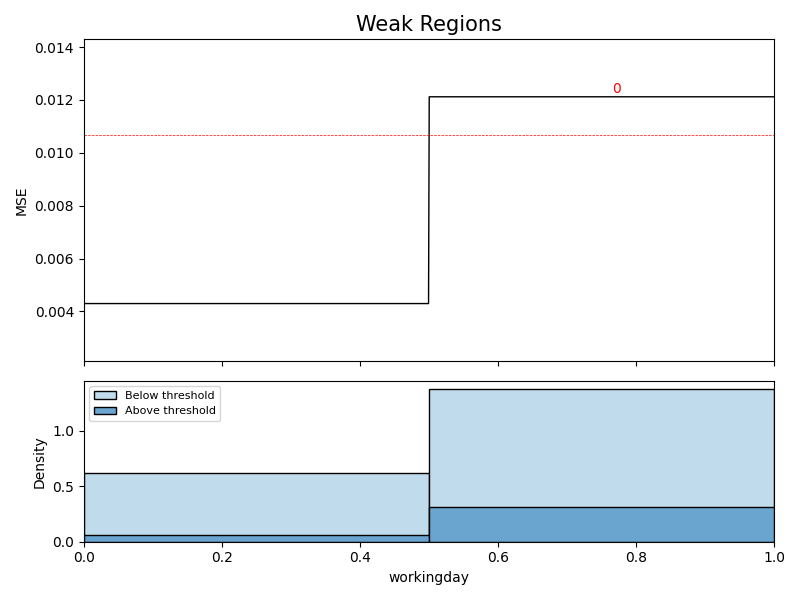

In [21]:
exp_bike_sharing.model_diagnose(model="DNN_Bike_Sharing", show="weakspot", slice_method="histogram", slice_features=["workingday"], metric="MSE", use_test=True, return_data=True)

### Q15 (10 pts): Compare the MSE and R2 for the two models used in biking sharing data set, for both training sample and testing. Plot the box plot for MSE and bar plot for R2.  Which model performs better based on out-of-sample evaluation metrics?

## Taiwan (TW) credit dataset with XGB model and DNN model

### Q16 (10 pts): Different from regression models, what may need to be calibrated in a classification model?  Use PiML to plot the reliability diagrams (or calibration curves) for both of the Taiwan credit data set models.  Then add a copy of that plot with 100 bins.  Which model is more reliable before calibration for the Taiwan credit data set?

### Q17 (5 pts): For the two models of TW credit dataset, which model performs better and why? Does any model potentially have overfitting problem and why?